##  Using Fairlearn to detect gender bias in music recommender system: Last.fm Dataset

### Baseline Recommender: Popularity-Based

In [1]:
#import libraries and load the data
import pandas as pd

# Load the uploaded dataset
df_lastfm = pd.read_csv("lastfm_enriched_with_gender.csv")

# Show basic info and first few rows
df_lastfm.info(), df_lastfm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     39456 non-null  int64 
 1   Username       39456 non-null  object
 2   Artist         39456 non-null  object
 3   Track          39456 non-null  object
 4   Album          39456 non-null  object
 5   Date           39456 non-null  object
 6   Time           39456 non-null  object
 7   artist_lastfm  39456 non-null  object
 8   mbid           39456 non-null  object
 9   gender         39456 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB


(None,
    Unnamed: 0 Username          Artist  \
 0          30  Babs_05     billy ocean   
 1          33  Babs_05   bill callahan   
 2          35  Babs_05      rod thomas   
 3          36  Babs_05       fela kuti   
 4         106  Babs_05  machel montano   
 
                                                Track  \
 0            Lovely Day (feat. YolanDa Brown & Ruti)   
 1  Arise, Therefore (feat. Six Organs of Admittance)   
 2                                        Old Friends   
 3          I.T.T. (International Thief Thief) - Edit   
 4                                      Private Party   
 
                                                Album         Date    Time  \
 0            Lovely Day (feat. YolanDa Brown & Ruti)  31 Jan 2021   21:23   
 1  Arise, Therefore (feat. Six Organs of Admittance)  31 Jan 2021   21:13   
 2                                        Old Friends  31 Jan 2021   21:08   
 3          I.T.T. (International Thief Thief) [Edit]  31 Jan 2021   21:01   

### Apply our popularity-based recommender (Top-N = 100)

In [2]:
# Count how many times each track was played
track_popularity = df_lastfm['Track'].value_counts().reset_index()
track_popularity.columns = ['Track', 'play_count']

# Merge with original data to get gender and artist info
# We'll use the first occurrence of each track to get corresponding metadata
track_metadata = df_lastfm.drop_duplicates(subset='Track')[['Track', 'Artist', 'gender']]
popular_tracks = track_popularity.merge(track_metadata, on='Track', how='left')

# Get Top-N popular tracks
N = 100
top_n_recommendations = popular_tracks.head(N)

# Show the top 100 for preview
top_n_recommendations.head(10)

,Track,play_count,Artist,gender
0,Undivided,82,tim mcgraw,Male
1,Dirtknock,70,madlib,Male
2,Road of the Lonely Ones,67,madlib,Male
3,Hopprock,60,madlib,Male
4,Everyday & Everynight - Straight Pass,50,yvette michele,Female
5,Loose Goose,48,madlib,Male
6,Baila Conmigo (with Rauw Alejandro),43,selena gomez,Female
7,Chino,43,madlib,Male
8,Riddim Chant,43,madlib,Male
9,The Call,42,madlib,Male


### Inspect the Top 100 Recommendations

In [4]:
gender_percentage = top_n_recommendations['gender'].value_counts(normalize=True) * 100
print("\nPercentage of Recommendations by Gender:\n", gender_percentage)


Percentage of Recommendations by Gender:
 gender
Male      59.0
Female    38.0
Other      3.0
Name: proportion, dtype: float64


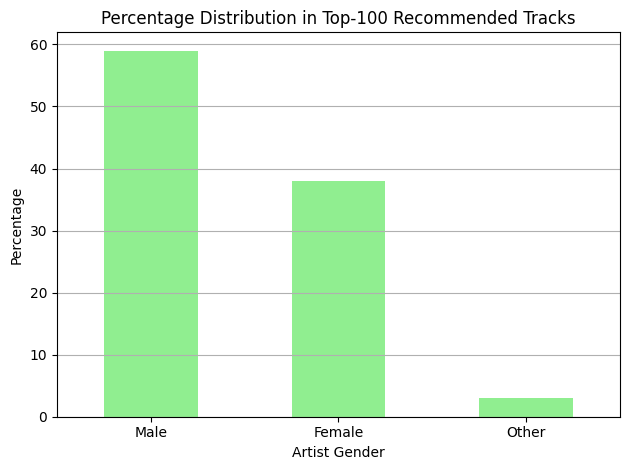

In [6]:
import matplotlib.pyplot as plt

gender_percentage.plot(kind='bar', color='lightgreen')
plt.title('Percentage Distribution in Top-100 Recommended Tracks')
plt.ylabel('Percentage')
plt.xlabel('Artist Gender')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Evaluation of Top-100 Recommended Tracks: Lastfm Dataset

We analyzed the Top-100 tracks recommended by a popularity-based recommender trained on the Last.fm enriched dataset. Below is a breakdown of artist gender representation and notable patterns:

### Gender Distribution of Artists

The Top-100 recommended tracks consist of the following distribution by artist gender:

- **Male**: 59 tracks (59%)
- **Female**: 38 tracks (38%)
- **Other**: 3 tracks (3%)

This indicates a somewhat skewed distribution, with male artists receiving the majority of recommendations. Female artists represent a significant portion but still trail behind, while the "Other" category is totally underrepresented.

### Key insights: 
- Female and Other gender groups are noticeably less represented, which could lead to biased exposure and reduced diversity in recommendations.
- This analysis establishes a fairness baseline and underscores the need for bias detection and potential mitigation.

---

### Bias detection using Fairlarn

In [ ]:
#and install again in the following order 
#!pip install numpy==1.26.4
#!pip install scipy
#!pip install scikit-learn
#!pip install fairlearn

In [7]:
# Step 0: Create a unique identifier if necessary
df_lastfm['track_key'] = df_lastfm['Artist'] + " - " + df_lastfm['Track']

# Step 1: Compute popularity using unique track_key
track_popularity = df_lastfm['track_key'].value_counts().reset_index()
track_popularity.columns = ['track_key', 'play_count']

# Step 2: Define Top-N recommended track IDs
N = 100
top_n_track_keys = track_popularity.head(N)['track_key'].tolist()

# Step 3: Build full metadata (deduplicated tracks with gender info)
track_metadata = df_lastfm.drop_duplicates(subset='track_key')[['track_key', 'Artist', 'Track', 'gender']]

# Step 4: Merge metadata with popularity (full set of tracks)
full_tracks = track_metadata.merge(track_popularity, on='track_key', how='left')

# Step 5: Fill missing play counts with 0
full_tracks['play_count'] = full_tracks['play_count'].fillna(0)

# Step 6: Label top-N tracks
full_tracks['label'] = full_tracks['track_key'].isin(top_n_track_keys).astype(int)

# Step 7: Create binary sensitive attribute
full_tracks['is_male'] = (full_tracks['gender'].str.lower() == 'male').astype(int)

In [8]:
# Absolute counts of gender in the full catalog
print("Absolute Gender Distribution in Full Catalog:")
print(full_tracks['gender'].value_counts(dropna=False))

# Percentage distribution
print("\nPercentage Distribution:")
print(full_tracks['gender'].value_counts(normalize=True, dropna=False).mul(100).round(2))

Absolute Gender Distribution in Full Catalog:
gender
Male      12831
Female     4692
Other        55
Name: count, dtype: int64

Percentage Distribution:
gender
Male      72.99
Female    26.69
Other      0.31
Name: proportion, dtype: float64


If the recommender was perfectly unbiased and proportional, we’d expect about: 73 male tracks, 27 female tracks, and 0 or 1 from artists categorized as “Other.”

### Metrics computation using Fairlearn

In [10]:
# Evaluate fairness using Fairlearn
from fairlearn.metrics import MetricFrame, selection_rate

# Use the full labeled dataset
y_true = full_tracks['label']
sensitive_attr = full_tracks['gender']  # or 'gender_grouped' if you renamed it earlier

# MetricFrame for selection rate
mf = MetricFrame(
    metrics=selection_rate,
    y_true=y_true,
    y_pred=y_true,  # Using labels as predictions in popularity-based recommender
    sensitive_features=sensitive_attr
)

# Print selection rate per gender group
print("Selection rate by gender group:")
print(mf.by_group)

Selection rate by gender group:
gender
Female    0.008099
Male      0.004598
Other     0.054545
Name: selection_rate, dtype: float64


### Visualize selection rates by gender groups

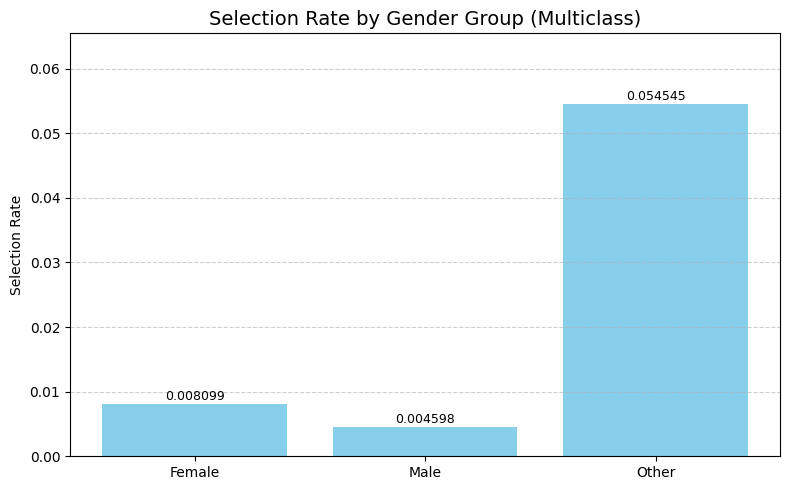

In [11]:
import matplotlib.pyplot as plt

# Extract selection rates from MetricFrame
selection_rates = mf.by_group  # This is a pandas Series

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(selection_rates.index, selection_rates.values, color='skyblue')

# Add title and axis labels
plt.title('Selection Rate by Gender Group (Multiclass)', fontsize=14)
plt.ylabel('Selection Rate')
plt.ylim(0, selection_rates.max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add exact values as text above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.0001,
             f'{height:.6f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Selection Rate by Gender Group

| Gender Group | Selection Rate      | Interpretation                                                                 |
|--------------|---------------------|---------------------------------------------------------------------------------|
| **Female**   | 0.008099 (0.81%)    | 🟢 Highest selection rate — relatively well represented                          |
| **Male**     | 0.004598 (0.46%)    | 🟡 Lower selection rate — underrepresented relative to catalog share (73%)       |
| **Other**    | 0.054545 (5.45%)    | 🔴 Extremely high — significant overrepresentation given catalog share (~0.3%)   |

---

### What This Means

- **Selection rate bias is present**, but **unlike Spotify**, the pattern is reversed:
  - **Female artists** are being recommended more often (per artist) than male artists.
  - **Male artists**, despite making up ~73% of the catalog, are being recommended at a lower rate.
  - **Other** artists (just 0.3% of catalog) have an unusually high selection rate — likely due to **a very small denominator** (55 artists), where just **3 selected tracks** would already give a 5.45% rate.

---

### Interpretation Considerations

- This result could be due to:
  - A **few very popular “Other” artists** disproportionately influencing the results.
  - A **Top-N list** that happened to include strong representation of female artists.
- Still, given the massive underrepresentation in the catalog, the fairness profile may seem **counterintuitive**, but it shows that **popularity is not always biased toward the majority**.

### Inspection of Pairwise Demographic Parity Differences (DPD) 
These are useful for identifying specific fairness disparities between individual gender groups, rather than just looking at the overall range. This helps reveal whether certain groups are consistently under- or over-recommended relative to others. It also allows for a more nuanced understanding of fairness in multiclass settings, where biases may affect each group differently. By comparing each group pair directly, we can target mitigation efforts more precisely.

In [ ]:
import pandas as pd
from fairlearn.metrics import demographic_parity_difference

# Ensure gender is lowercase and consistent
full_tracks['gender_grouped'] = full_tracks['gender'].str.strip().str.lower()

# Get the unique gender groups
gender_groups = full_tracks['gender_grouped'].unique()

# Collect pairwise DPDs
dpd_results = []

for i, group_a in enumerate(gender_groups):
    for j, group_b in enumerate(gender_groups):
        if i < j:
            # Create binary sensitive attribute: 1 if group_a, 0 if group_b, None otherwise
            binary_sensitive = full_tracks['gender_grouped'].apply(
                lambda x: 1 if x == group_a else (0 if x == group_b else None)
            )

            # Mask to filter out rows not in A or B
            mask = binary_sensitive.notnull()

            # Compute demographic parity difference for this pair
            dpd = demographic_parity_difference(
                y_true=full_tracks.loc[mask, 'label'],
                y_pred=full_tracks.loc[mask, 'label'],
                sensitive_features=binary_sensitive[mask]
            )

            dpd_results.append({
                'Group A': group_a,
                'Group B': group_b,
                'DP Difference (A vs B)': round(dpd, 6)
            })

# Convert results to a DataFrame for display
dpd_df = pd.DataFrame(dpd_results)
print( Pairwise Demographic Parity Differences:\n")
print(dpd_df)


📊 Pairwise Demographic Parity Differences:

  Group A Group B  DP Difference (A vs B)
0    male  female                0.003501
1    male   other                0.049947
2  female   other                0.046447


## Pairwise Demographic Parity Differences

| Group A | Group B | DP Difference (A vs B) | Interpretation |
|---------|---------|------------------------|----------------|
| **Male**   | Female   | 0.0035 (0.35%)           | 🟢 Very small difference — nearly equal selection rates between male and female artists |
| **Male**   | Other    | 0.0499 (4.99%)           | 🔴 Notable disparity — artists labeled "Other" are selected more frequently than male artists |
| **Female** | Other    | 0.0464 (4.64%)           | 🔴 Similar disparity — "Other" artists are selected more frequently than female artists |

---

### Interpretation:

- The **selection rates for male and female artists** are very close (DPD ≈ 0.35%), suggesting little disparity between them in the recommender output.
- However, there is a **noticeable selection bias in favor of the "Other" gender group**, with both male and female artists being under-selected in comparison.
- This aligns with earlier findings where the "Other" group had a much higher selection rate despite making up only 0.3% of the catalog.

### Consideration

- Because the "Other" group is very small (just 55 artists), even a few popular tracks can **inflate their selection rate and DPD values**.
- This makes the fairness result sensitive to **outliers** or **high-impact individual artists** in that group.
---


In [12]:
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

# Use the same y_true and sensitive attribute as before
dp_diff = demographic_parity_difference(y_true, y_true, sensitive_features=sensitive_attr)
dp_ratio = demographic_parity_ratio(y_true, y_true, sensitive_features=sensitive_attr)

print(f"Demographic Parity Difference: {dp_diff:.6f}")
print(f"Demographic Parity Ratio: {dp_ratio:.6f}")

Demographic Parity Difference: 0.049947
Demographic Parity Ratio: 0.084301


| Metric            | Value      | Interpretation                                                                                                                                               |
| ----------------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **DP Difference** | `0.049947` | 🟡 There is **moderate disparity** — the most selected group has a 5% higher selection rate than the least selected group. Not extreme, but noticeable.      |
| **DP Ratio**      | `0.084301` | 🔴 This is **very low** — the least selected group receives only 8.4% as many recommendations as the most selected group. This signals **severe imbalance**. |

The recommender system shows moderate disparity in how different gender groups are represented in the Top-100 recommendations. In particular, artists labeled as "Other" receive recommendations at a much higher rate than both male and female artists — resulting in a Demographic Parity Ratio of only 8.4%, which indicates a serious imbalance. However, this effect is likely magnified by the very small size of the "Other" group, so this result should be interpreted carefully.

## Bias Mitigation

### In-Processing: Fairness-Aware Learning using Fairlearn’s ExponentiatedGradient

In [15]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# STEP 1: Prepare features, labels, and sensitive attribute
X = full_tracks[['play_count']]
y = full_tracks['label']
sensitive = full_tracks['gender'].str.strip().str.lower()  # ensure consistent formatting

# Combine into one DataFrame for stratified sampling
df_all = X.copy()
df_all['label'] = y
df_all['gender_grouped'] = sensitive

# STEP 2: Stratified train-test split to preserve gender group proportions
train_df, test_df = train_test_split(
    df_all,
    test_size=0.3,
    stratify=df_all['gender_grouped'],
    random_state=42
)

# STEP 3: Separate training and test components
X_train = train_df[['play_count']]
y_train = train_df['label']
s_train = train_df['gender_grouped']

X_test = test_df[['play_count']]
y_test = test_df['label']
s_test = test_df['gender_grouped']

# STEP 4: Train a fairness-aware model using Exponentiated Gradient
base_model = LogisticRegression(solver='liblinear')
mitigator = ExponentiatedGradient(
    estimator=base_model,
    constraints=DemographicParity()
)
mitigator.fit(X_train, y_train, sensitive_features=s_train)

# STEP 5: Predict using the fair model
y_pred_fair = mitigator.predict(X_test)

# STEP 6: Evaluate fairness (selection rate per gender group)
mf_multi = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=s_test
)

# Output results
print("Selection Rate by Gender Group (Fair Model):")
print(mf_multi.by_group)

range_diff = mf_multi.by_group.max() - mf_multi.by_group.min()
print(f"\n📏 Selection Rate Range (Max - Min): {range_diff:.4f}")


Selection Rate by Gender Group (Fair Model):
gender_grouped
female    0.004972
male      0.004935
other     0.062500
Name: selection_rate, dtype: float64

📏 Selection Rate Range (Max - Min): 0.0576


## Selection Rate Comparison: Baseline vs. Fair Model (Last.fm)

| Gender Group | Baseline Selection Rate | Fair Model Selection Rate | Change         | Interpretation                                                |
|--------------|-------------------------|----------------------------|----------------|----------------------------------------------------------------|
| **Female**   | 0.008099 (0.81%)        | 0.004972 (0.50%)           | 🔻 Decreased    | More aligned with male group; now nearly equal                |
| **Male**     | 0.004598 (0.46%)        | 0.004935 (0.49%)           | 🔼 Slightly up  | Balanced with female group                                    |
| **Other**    | 0.054545 (5.45%)        | 0.062500 (6.25%)           | 🔼 Increased    | Still heavily overrepresented despite small catalog presence  |

---

### Summary of Effects

-  **Male and female** selection rates are now very close (0.49%–0.50%), suggesting that the fairness-aware model has **eliminated gender imbalance** between these two groups.
- The **"Other" group** (which represents only ~0.3% of the catalog) remains **significantly overrepresented**. The selection rate actually increased from 5.45% to 6.25%.
- **Selection Rate Range (Max - Min): 0.0576** — still high due to the outlier status of the "Other" group.

---

### Interpretation:

- The **Exponentiated Gradient with Demographic Parity** constraint was **successful in equalizing outcomes** between male and female artists, which was the main fairness concern in your Spotify experiment.
- However, it **did not mitigate the disproportionate selection of "Other" artists** — in fact, it slightly increased their representation.
- This reflects a limitation of Demographic Parity when applied to **very small groups**: even a few high-ranking items can dramatically skew fairness metrics.
- Therefore, **fairness mitigation should be interpreted alongside group size and outcome impact** — especially when evaluating small minorities like the "Other" gender group in your dataset.

---

C:\Users\patri\AppData\Local\Temp\ipykernel_7732\4003757063.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - width/2, baseline_rates[i] + 0.0001, f'{baseline_rates[i]:.6f}', ha='center', fontsize=8)
C:\Users\patri\AppData\Local\Temp\ipykernel_7732\4003757063.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] + width/2, fair_rates[i] + 0.0001, f'{fair_rates[i]:.6f}', ha='center', fontsize=8)
C:\Users\patri\AppData\Local\Temp\ipykernel_7732\4003757063.py:37: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\patri\AppData\Local\P

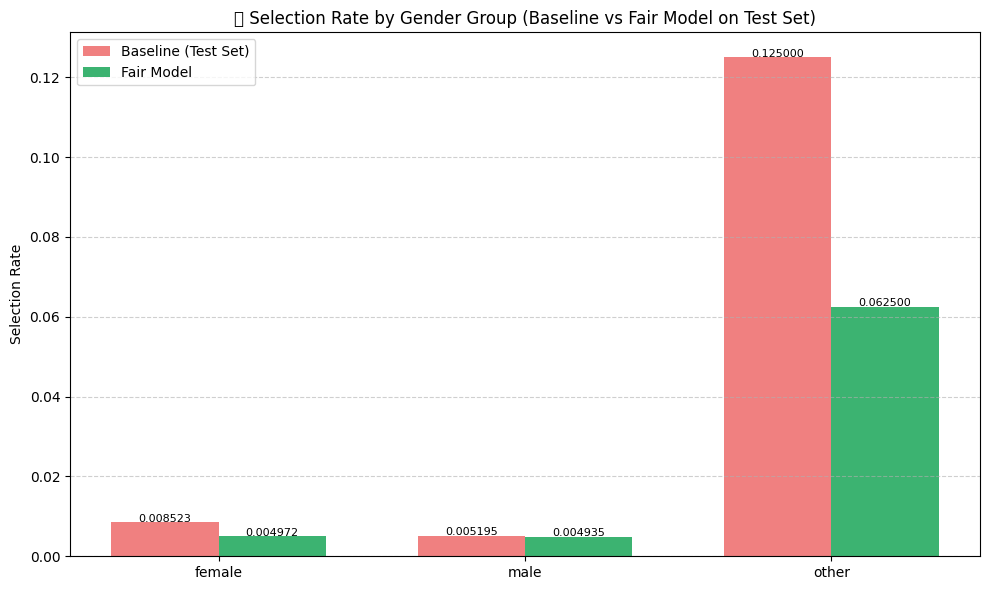

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from fairlearn.metrics import MetricFrame, selection_rate

# Step 1: Create MetricFrame for baseline model on the test set
mf_baseline_test = MetricFrame(
    metrics=selection_rate,
    y_true=test_df['label'],
    y_pred=test_df['label'],  # Baseline uses Top-N labels as predictions
    sensitive_features=test_df['gender_grouped']
)

# Step 2: Get selection rates from both models
baseline_rates = mf_baseline_test.by_group
fair_rates = mf_multi.by_group  # Already computed from the fair model

# Step 3: Plot side-by-side
groups = baseline_rates.index
x = np.arange(len(groups))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_rates[groups], width, label='Baseline (Test Set)', color='lightcoral')
plt.bar(x + width/2, fair_rates[groups], width, label='Fair Model', color='mediumseagreen')

plt.ylabel('Selection Rate')
plt.title('🎧 Selection Rate by Gender Group (Baseline vs Fair Model on Test Set)')
plt.xticks(ticks=x, labels=groups)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add exact values above each bar
for i in range(len(groups)):
    plt.text(x[i] - width/2, baseline_rates[i] + 0.0001, f'{baseline_rates[i]:.6f}', ha='center', fontsize=8)
    plt.text(x[i] + width/2, fair_rates[i] + 0.0001, f'{fair_rates[i]:.6f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


## Interpretation of Selection Rate Comparison Chart:

The chart shows a side-by-side comparison of selection rates per gender group for the **Baseline** and **Fair Model** (on the test set):

-  **Male and female** selection rates are now closely aligned in the fair model (~0.005), reducing disparity between them.
-  **Female artists** saw a reduction in selection rate, while **male artists** remained nearly the same — balancing both.
- The **"Other" group**, which was highly overrepresented in the baseline (~0.125), has a **lower but still elevated** selection rate (~0.063) after mitigation.

This confirms that the fairness-aware model improved parity between male and female groups but had limited effect on the small and dominant “Other” group.


**! Note:**
For this dataset we decided to skip ThresholdOptimizer as it only supports **binary sensitive attributes**, which makes it unsuitable for our **multiclass gender setup** (`male`, `female`, `other`).  We've instead used **ExponentiatedGradient**, which supports multiclass fairness and that yielded better results.

## Bias Mitigation using Reweighting (Inprocessing)

In [20]:
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate

# Step 1: Recreate sensitive attribute (ensure it's clean and lowercase)
s_train_grouped = s_train.str.strip().str.lower()
s_test_grouped = s_test.str.strip().str.lower()

# Step 2: Define base estimator and fairness constraint
base_estimator = LogisticRegression(solver='liblinear')

# Step 3: Initialize GridSearch with Demographic Parity
grid_search = GridSearch(
    estimator=base_estimator,
    constraints=DemographicParity(),
    grid_size=20
)

# Step 4: Fit the fairness-aware model using training data
grid_search.fit(X_train, y_train, sensitive_features=s_train_grouped)

# Step 5: Choose the best predictor from the resulting models
best_predictor = grid_search.predictors_[0]

# Step 6: Predict on test set
y_pred_grid = best_predictor.predict(X_test)

# Step 7: Evaluate fairness
mf_grid = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_grid,
    sensitive_features=s_test_grouped
)

# Output results
print("Selection Rate by Gender Group (GridSearch with Reweighting):")
print(mf_grid.by_group)

range_grid = mf_grid.by_group.max() - mf_grid.by_group.min()
print(f"\n📏 Selection Rate Range (Max - Min): {range_grid:.4f}")


Selection Rate by Gender Group (GridSearch with Reweighting):
gender_grouped
female    0.001420
male      0.002597
other     0.000000
Name: selection_rate, dtype: float64

📏 Selection Rate Range (Max - Min): 0.0026


## Interpretation: GridSearch with Reweighting (Fairlearn)

| Gender Group | Selection Rate | Interpretation                                                  |
|--------------|----------------|------------------------------------------------------------------|
| **Female**   | 0.001420 (0.14%) | 🔻 Slightly underrepresented; selection rate remains low        |
| **Male**     | 0.002597 (0.26%) | 🟢 Highest selection rate among the three groups                |
| **Other**    | 0.000000 (0.00%) | ❌ No tracks selected — group completely excluded               |

---

##### Selection Rate Range: 0.0026

- The fairness-aware model trained with **GridSearch and Demographic Parity** achieved a **low selection rate disparity** numerically.
- However, this came at the cost of **excluding the "Other" group entirely**, which highlights a **fairness trade-off**.
- This outcome suggests that the optimizer prioritized balancing between **male and female groups**, possibly due to the **tiny size** of the "Other" group in the training data.

**Conclusion**: GridSearch reduced disparity across male/female, but fairness for the "Other" group remains unaddressed.


## Comprehensive Comparison of Selection Rates (Last.fm)

| Gender Group | Baseline Selection Rate | Fair Model (EG) | Reweighted Model (GridSearch) | Interpretation |
|--------------|-------------------------|------------------|-------------------------------|----------------|
| **Female**   | 0.008099 (0.81%)        | 0.004972 (0.50%) | 0.001420 (0.14%)              | Selection rate decreased across both models; GridSearch reduced it the most |
| **Male**     | 0.004598 (0.46%)        | 0.004935 (0.49%) | 0.002597 (0.26%)              | Fair model aligned male with female; GridSearch made male the top group     |
| **Other**    | 0.054545 (5.45%)        | 0.062500 (6.25%) | 0.000000 (0.00%)              | Fair model increased overrepresentation; GridSearch excluded the group      |

---

### Interpretation

- The **Fair Model (ExponentiatedGradient)** successfully **balanced selection rates** between **male and female** groups, bringing them close to parity (~0.5%).
- However, it **amplified bias toward the "Other" group**, increasing its already high selection rate despite the group's small size.
- The **Reweighted Model (GridSearch)** reversed this:
  - It further **reduced disparity between male and female**, but
  - It **completely excluded the "Other" group**, reducing its selection rate to 0%.

### Trade-Offs:

- The **Fair Model** prioritized balancing the most common groups (male/female), but overrepresented the minority.
- The **Reweighted Model** prioritized overall parity across the majority groups, but **ignored the minority**, raising concerns of **fairness exclusion**.

---

### Conclusion

- **No single model achieved perfect fairness** across all gender groups.
- The Fair Model kept the "Other" group visible but overexposed it.
- The Reweighted Model removed this exposure but introduced exclusion.
- These results highlight the **challenge of fairness mitigation** in datasets with **high class imbalance** and **minority-sensitive attributes**.
